## Tutorial 2: Look into the ZigZag API function
This tutorial show you the implementation of the ZigZag API function.

By the end of this tutorial, you will get a general idea of **the stage concept** (the key programming concept of the whole ZigZag project), and how to customize stages to meet different goals.

Let's have a look of the API function implementation

In [1]:
from zigzag.classes.stages import *

def get_hardware_performance_zigzag(workload,
                                    accelerator,
                                    mapping,
                                    opt='latency',
                                    dump_filename_pattern="outputs/{datetime}.json",
                                    pickle_filename="outputs/list_of_cmes.pickle"):
    # Initialize the logger
    import logging as _logging
    _logging_level = _logging.INFO
    _logging_format = '%(asctime)s - %(funcName)s +%(lineno)s - %(levelname)s - %(message)s'
    _logging.basicConfig(level=_logging_level,
                         format=_logging_format)

    # Sanity check on the optimization criterion
    if opt == 'energy':
        opt_stage = MinimalEnergyStage
    elif opt == 'latency':
        opt_stage = MinimalLatencyStage
    elif opt == 'EDP':
        opt_stage = MinimalEDPStage
    else:
        raise NotImplementedError("Optimization criterion 'opt' should be either 'energy' or 'latency' or 'EDP'.")

    # Check workload format and based on it select the correct workload parser stage
    try:
        if workload.split('.')[-1] == 'onnx':
            workload_parser_stage = ONNXModelParserStage
        else:
            workload_parser_stage = WorkloadParserStage
    except:
        workload_parser_stage = WorkloadParserStage

    mainstage = MainStage([  # Initialize the MainStage as entry point
        workload_parser_stage,  # Parse the ONNX Model into the workload
        AcceleratorParserStage,  # Parse the accelerator module/passthrough given accelerator
        SimpleSaveStage,  # Save the summed CME energy and latency to a json
        PickleSaveStage,  # Save all received CMEs in a list to a pickle file
        SumStage,  # Sum up the received best CME across all layers of the workload
        WorkloadStage,  # Iterate through the different layers in the workload
        CompleteSaveStage,  # Save each processed layer to a json
        opt_stage,  # Reduce all CMEs, returning minimal energy/latency one
        SpatialMappingGeneratorStage,  # Generate multiple spatial mappings (SM)
        opt_stage,  # Reduce all CMEs, returning minimal energy/latency one
        LomaStage,  # Generate multiple temporal mappings (TM)
        # SalsaStage,  # Generate multiple temporal mappings (TM)
        # TemporalOrderingConversionStage,  # Based on the fixed temporal mapping order, generate one temporal mapping (TM)
        CostModelStage  # Evaluate generated SM and TM through cost model
    ],
        accelerator=accelerator,  # required by AcceleratorParserStage
        workload=workload,  # required by workload_parser_stage
        mapping=mapping,  # required by workload_parser_stage
        dump_filename_pattern=dump_filename_pattern,  # output file save pattern
        pickle_filename=pickle_filename,  # filename for pickled list of cmes
        loma_lpf_limit=6,  # required by LomaStage
        loma_show_progress_bar=True,
    )

    # Launch the MainStage
    answers = mainstage.run()
    # Get CME from answer
    cmes = answers

    return cmes[0][0].energy_total, cmes[0][0].latency_total2, cmes

Define the mapping (fixed temporal ordering for now)

In [2]:
mapping = {
    "Conv": {
        "core_allocation": 1,
        "spatial_mapping": {'D1': ('K', 32), 'D2': ('C', 32)},
        "memory_operand_links": {'O': 'O', 'W': 'I2', 'I': 'I1'},
        "temporal_ordering": [('K', 2), ('C', 2), ('OY', 56), ('OX', 56), ('FY', 3), ('FX', 3)]  # from left to right -> from the innermost memory to the off-chip
    }
}

Define our own HW architecture

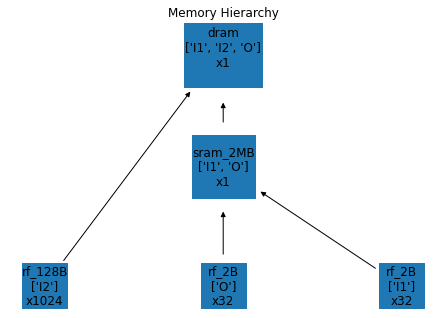

NameError: name '__file__' is not defined

In [4]:
from zigzag.classes.hardware.architecture.memory_hierarchy import MemoryHierarchy
from zigzag.classes.hardware.architecture.operational_unit import Multiplier
from zigzag.classes.hardware.architecture.operational_array import MultiplierArray
from zigzag.classes.hardware.architecture.memory_instance import MemoryInstance
from zigzag.classes.hardware.architecture.accelerator import Accelerator
from zigzag.classes.hardware.architecture.core import Core

def memory_hierarchy_dut(multiplier_array):
    """Memory hierarchy variables"""
    ''' size=#bit, bw=(read bw, write bw), cost=(read word energy, write work energy) '''

    reg_128B = MemoryInstance(name="rf_128B", size=128 * 8, r_bw=8, w_bw=8, r_cost=0.095, w_cost=0.095, area=0,
                                r_port=1, w_port=1, rw_port=0, latency=1)

    reg_2B = MemoryInstance(name="rf_2B", size=16, r_bw=16, w_bw=16, r_cost=0.021, w_cost=0.021, area=0,
                              r_port=2, w_port=2, rw_port=0, latency=1)

    sram_2M_with_16_128K_bank_128_1r_1w = \
        MemoryInstance(name="sram_2MB", size=131072 * 16 * 8, r_bw=128 * 16, w_bw=128 * 16, r_cost=26.01 * 16, w_cost=23.65 * 16, area=0,
                       r_port=1, w_port=1, rw_port=0, latency=1, min_r_granularity=64, min_w_granularity=64)

    dram = MemoryInstance(name="dram", size=10000000000, r_bw=64, w_bw=64, r_cost=700, w_cost=750, area=0,
                          r_port=0, w_port=0, rw_port=1, latency=1)

    memory_hierarchy_graph = MemoryHierarchy(operational_array=multiplier_array)

    '''
    fh: from high = wr_in_by_high
    fl: from low = wr_in_by_low
    th: to high = rd_out_to_high
    tl: to low = rd_out_to_low
    '''
    memory_hierarchy_graph.add_memory(memory_instance=reg_128B, operands=('I2',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': None, 'th': None},),
                                      served_dimensions={(0, 0)})

    memory_hierarchy_graph.add_memory(memory_instance=reg_2B, operands=('O',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': 'w_port_2', 'th': 'r_port_2'},),
                                      served_dimensions={(0, 1)})

    memory_hierarchy_graph.add_memory(memory_instance=reg_2B, operands=('I1',),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': 'w_port_2', 'th': 'r_port_2'},),
                                      served_dimensions={(1, 0)})

    memory_hierarchy_graph.add_memory(memory_instance=sram_2M_with_16_128K_bank_128_1r_1w, operands=('I1', 'O'),
                                      port_alloc=({'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'w_port_1', 'tl': 'r_port_1', 'fl': 'w_port_1', 'th': 'r_port_1'},),
                                      served_dimensions='all')

    memory_hierarchy_graph.add_memory(memory_instance=dram, operands=('I1', 'I2', 'O'),
                                      port_alloc=({'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': None, 'th': None},
                                                  {'fh': 'rw_port_1', 'tl': 'rw_port_1', 'fl': 'rw_port_1', 'th': 'rw_port_1'},),
                                      served_dimensions='all')

    from zigzag.visualization.graph.memory_hierarchy import visualize_memory_hierarchy_graph
    visualize_memory_hierarchy_graph(memory_hierarchy_graph)
    return memory_hierarchy_graph


def multiplier_array_dut():
    """ Multiplier array variables """
    multiplier_input_precision = [8, 8]
    multiplier_energy = 0.04
    multiplier_area = 1
    dimensions = {'D1': 32, 'D2': 32}  # {'D1': ('K', 32), 'D2': ('C', 32)}

    multiplier = Multiplier(multiplier_input_precision, multiplier_energy, multiplier_area)
    multiplier_array = MultiplierArray(multiplier, dimensions)

    return multiplier_array


def cores():
    multiplier_array1 = multiplier_array_dut()
    memory_hierarchy1 = memory_hierarchy_dut(multiplier_array1)
    core1 = Core(1, multiplier_array1, memory_hierarchy1)
    return {core1}


cores = cores()
global_buffer = None
acc_name = 'our_own_accelerator'
accelerator = Accelerator(acc_name, cores, global_buffer)